In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
%matplotlib inline

In [2]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
multiplier = 50
min_tick = 0.25

In [3]:
contract = contract.loc['20180202':]

In [4]:
periods = [5, 10, 20, 40, 80, 160, 320]
ema_fast = 120 # number of periods for moving average filter
sl_atr = 3 # stop loss in ATRs
atr_periods = 80 # number of periods to calculate ATR on
time_int = 60 # interval in minutes to be used to define volume candle
commission = 2.1 # level of commision per transaction in dollars
bankroll = 15000

In [5]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

63604.29326641914

In [6]:
#avg_vol = 14913

In [7]:
vol_candles = group_by_volume(contract, avg_vol)
vol_candles['atr'] = get_ATR(vol_candles, atr_periods)

In [8]:
vol_candles

,date,open,high,low,close,barCount,volume,atr
label,,,,,,,,
0,2018-02-02 04:02:00,2826.50,2831.00,2811.75,2817.50,13141,63333,19.250000
1,2018-02-02 09:59:00,2817.25,2821.25,2807.75,2808.75,14544,62759,16.339063
2,2018-02-02 11:17:00,2808.75,2810.25,2797.00,2800.50,13327,64130,15.283527
3,2018-02-02 13:43:00,2800.50,2806.00,2799.00,2806.00,12870,65988,13.134348
4,2018-02-02 14:40:00,2805.75,2807.25,2799.50,2802.50,11061,63423,12.002971
...,...,...,...,...,...,...,...,...
9065,2019-09-04 21:59:00,2938.25,2938.75,2936.75,2938.25,5087,59743,7.924526
9066,2019-09-05 02:38:00,2938.25,2945.25,2936.50,2943.50,13944,81663,7.944908
9067,2019-09-05 03:52:00,2943.75,2964.50,2941.50,2964.25,16532,62567,8.316639


In [9]:
max_candles = pd.DataFrame()
min_candles = pd.DataFrame()
for period in periods:
    max_candles[period] = (vol_candles.close - vol_candles.close.rolling(period).max())
    min_candles[period] = -(vol_candles.close - vol_candles.close.rolling(period).min())
max_candles['total_max'] = max_candles.mean(axis=1) + 30
min_candles['total_min'] = min_candles.mean(axis=1) + 30
max_candles['total_max'] = max_candles['total_max'].rolling(100).mean() 
min_candles['total_min'] = min_candles['total_min'].rolling(100).mean() 
max_candles['total_max'] = (max_candles['total_max'] > 0) * 1
min_candles['total_min'] = (min_candles['total_min'] > 0) *-1
total = max_candles['total_max'] + min_candles['total_min']

In [10]:
data = vol_candles.copy()
data['ema'] = data.close.ewm(span=ema_fast).mean()
rows_to_drop = max(periods)
data = data.iloc[rows_to_drop:]
data.reset_index(drop=True, inplace=True)

In [11]:
data['signal'] = total
data['filter'] = np.sign(data['close'] - data['ema'])
#data['filtered_signal'] = data['signal'] * ((data['signal'] * data['filter']) == 1)
data['filtered_signal'] = data['signal']

In [12]:
# while in position maintain open price and transaction direction
data['positions'] = 0
# flag to execute transaction at next data point
data['mark'] = False
# note the reason for transaction at next data point
data['reason'] = ''
# record commission paid
data['commission'] = 0
# record transaction price
data['price'] = 0
# entry price for stop loss calculation
data['entry'] = 0

for item in data.itertuples(): 
    # first row doesn't have to check if we have positions or execute transactions
    if not item.Index == 0:
        # starting position is the same as previous day position
        data.loc[item.Index, 'positions'] = data.loc[(item.Index - 1), 'positions'] 
        data.loc[item.Index, 'entry'] = data.loc[(item.Index - 1), 'entry'] 
        # execute transactions
        if data.loc[(item.Index -  1), 'mark']:
            # close position
            if data.loc[item.Index, 'positions']:
                data.loc[item.Index, 'positions'] = 0
                data.loc[item.Index, 'entry'] = 0
                # record transaction price
                data.loc[item.Index, 'price'] = item.open * np.sign(data.loc[(item.Index - 1), 'entry']) * -1
            # open position
            else:
                data.loc[item.Index, 'positions'] = data.loc[(item.Index - 1), 'signal']
                data.loc[item.Index, 'entry'] = item.open * data.loc[(item.Index - 1), 'signal']
                # record transaction price
                data.loc[item.Index, 'price'] = item.open * data.loc[(item.Index -1), 'signal']
            # record commission paid
            data.loc[item.Index, 'commission'] = commission

    # check for close signal
    if data.loc[item.Index, 'positions'] != 0 and item.signal == 0:
        data.loc[item.Index, 'mark'] = True
        data.loc[item.Index, 'reason'] = 'close'
    # check for stop-loss signal
    # long positions
    if data.loc[item.Index, 'positions'] > 0:
        if item.close <= (data.loc[item.Index, 'entry'] - (item.atr * sl_atr)):
            data.loc[item.Index, 'mark'] = True
            data.loc[item.Index, 'reason'] = 'stop-out'
    # short positions
    if data.loc[item.Index, 'positions'] < 0:
        if item.close >= abs((data.loc[item.Index, 'entry'] - (item.atr * sl_atr))):
            data.loc[item.Index, 'mark'] = True
            data.loc[item.Index, 'reason'] = 'stop-out'
    # check for entry signal
    if data.loc[item.Index, 'positions'] == 0:
        if item.filtered_signal != 0:
            data.loc[item.Index, 'mark'] = True
            data.loc[item.Index, 'reason'] = 'entry'
# close any open positions
if data[data.price != 0].price.count() % 2 != 0:
    data.loc[data.index[-1]+1, 'price'] = data.open.iloc[-1] * np.sign(data.entry.iloc[-1]) * -1
    data.loc[data.index[-2]+1, 'entry'] = 0
data.set_index('date', inplace=True)

In [13]:
data.tail(50)

,open,high,low,close,barCount,volume,atr,ema,signal,filter,filtered_signal,positions,mark,reason,commission,price,entry
date,,,,,,,,,,,,,,,,,
2019-09-02 09:26:00,2910.25,2918.75,2906.25,2917.50,18246,63930,8.709239,2903.006585,0,1.0,0,0,False,,0.0,0.0,0.0
2019-09-02 13:01:00,2917.50,2926.50,2914.50,2924.25,15665,63830,8.790493,2903.357716,0,1.0,0,0,False,,0.0,0.0,0.0
2019-09-02 17:10:00,2924.25,2924.25,2910.75,2911.50,15466,62621,8.906777,2903.492299,0,1.0,0,0,False,,0.0,0.0,0.0
2019-09-02 18:58:00,2911.50,2915.25,2889.00,2901.00,18835,63726,9.335005,2903.451104,0,-1.0,0,0,False,,0.0,0.0,0.0
2019-09-03 06:26:00,2901.00,2915.50,2898.25,2909.00,20548,65048,9.530437,2903.542821,0,1.0,0,0,False,,0.0,0.0,0.0
2019-09-03 09:16:00,2909.00,2913.75,2897.25,2898.00,18536,63254,9.702525,2903.451204,0,-1.0,0,0,False,,0.0,0.0,0.0
2019-09-03 10:36:00,2898.00,2911.00,2894.75,2903.75,14569,63981,9.864191,2903.456143,0,1.0,0,0,False,,0.0,0.0,0.0
2019-09-03 12:25:00,2904.00,2909.00,2894.25,2901.25,13710,64240,9.984828,2903.419678,0,-1.0,0,0,False,,0.0,0.0,0.0
2019-09-03 14:28:00,2901.00,2907.00,2899.75,2905.25,13372,59830,9.917301,2903.449931,0,1.0,0,0,False,,0.0,0.0,0.0


In [14]:
pnl = data[['open','positions', 'commission', 'mark', 'reason', 'price', 'entry']]
pnl['mark'] = pnl['mark'].shift(1)
pnl['reason'] = pnl['reason'].shift(1)

In [15]:
pnl

,open,positions,commission,mark,reason,price,entry
date,,,,,,,
2018-02-12 21:27:00,2662.75,0,0.0,NaN,NaN,0.0,0.0
2018-02-12 21:40:00,2666.00,0,0.0,False,,0.0,0.0
2018-02-12 21:47:00,2662.75,0,0.0,False,,0.0,0.0
2018-02-12 21:56:00,2655.25,0,0.0,False,,0.0,0.0
2018-02-12 21:58:00,2656.25,0,0.0,False,,0.0,0.0
...,...,...,...,...,...,...,...
2019-09-04 21:59:00,2938.25,0,0.0,False,,0.0,0.0
2019-09-05 02:38:00,2938.25,0,0.0,False,,0.0,0.0
2019-09-05 03:52:00,2943.75,0,0.0,False,,0.0,0.0


In [16]:
-pnl.price.sum() * multiplier

4087.5

In [17]:
pnl = pnl[pnl.price != 0]
pnl['close'] = pnl.price.shift(-1)
pnl = pnl[pnl.reason == 'entry']
pnl['pnl'] = -(pnl.entry + pnl.close) * multiplier
pnl['net_pnl'] = pnl.pnl - 2 * pnl.commission
pnl['cum_pnl'] = pnl.pnl.cumsum()
pnl['net_cum_pnl'] = pnl.net_pnl.cumsum()
pnl['balance'] = bankroll + pnl.net_cum_pnl
pnl

,open,positions,commission,mark,reason,price,entry,close,pnl,net_pnl,cum_pnl,net_cum_pnl,balance
date,,,,,,,,,,,,,
2018-02-16 21:44:00,2740.25,-1,2.1,True,entry,-2740.25,-2740.25,2728.00,612.5,608.3,612.5,608.3,15608.3
2018-03-01 16:42:00,2725.00,-1,2.1,True,entry,-2725.00,-2725.00,2677.00,2400.0,2395.8,3012.5,3004.1,18004.1
2018-03-06 20:15:00,2733.75,1,2.1,True,entry,2733.75,2733.75,-2701.00,-1637.5,-1641.7,1375.0,1362.4,16362.4
2018-03-07 05:15:00,2689.25,1,2.1,True,entry,2689.25,2689.25,-2661.75,-1375.0,-1379.2,0.0,-16.8,14983.2
2018-03-23 18:40:00,2638.50,-1,2.1,True,entry,-2638.50,-2638.50,2677.75,-1962.5,-1966.7,-1962.5,-1983.5,13016.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-05 20:56:00,2836.25,1,2.1,True,entry,2836.25,2836.25,-2787.00,-2462.5,-2466.7,4962.5,4660.1,19660.1
2019-08-06 03:14:00,2791.00,1,2.1,True,entry,2791.00,2791.00,-2848.25,2862.5,2858.3,7825.0,7518.4,22518.4
2019-08-15 19:36:00,2849.50,-1,2.1,True,entry,-2849.50,-2849.50,2883.25,-1687.5,-1691.7,6137.5,5826.7,20826.7


In [18]:
pnl.pnl.sum()

4087.5

In [19]:
pnl.net_pnl.sum()

3768.2999999999993

In [20]:
# percentage of winning transactions
win_pct = round(pnl[pnl.pnl > 0].pnl.count() / pnl.pnl.count(), 4)
win_pct

0.3289

In [21]:
# avg. win,  avg. lose, ratio
avg_win = round(pnl[pnl.pnl > 0].pnl.mean(), 2)
avg_lose = round(pnl[pnl.pnl < 0].pnl.mean(), 2)
ratio = round(abs(avg_win / avg_lose), 2)
avg_win, avg_lose, ratio

(2876.5, -1329.9, 2.16)

In [22]:
# transaction EV
ev = win_pct * avg_win + (1 - win_pct) * avg_lose
ev

53.58495999999991

In [23]:
# number of positions
pnl.pnl.count()

76

In [24]:
pnl.pnl.count() * ev

4072.456959999993

In [25]:
pnl.pnl.min(), pnl.pnl.max(), round(abs(pnl.pnl.max() / pnl.pnl.min()), 1)

(-2562.5, 9312.5, 3.6)

In [26]:
daily = pnl.resample('B').last()
daily['return'] = daily.balance.pct_change()
daily['return'].iloc[0] = daily.balance.iloc[0] / bankroll - 1

In [27]:
data.commission.sum()

319.2

In [28]:
perf_stats(daily['return'])

Annual return           0.154973
Cumulative returns      0.251220
Annual volatility       1.173725
Sharpe ratio            0.620716
Calmar ratio            0.260651
Stability               0.670544
Max drawdown           -0.594559
Omega ratio             1.343238
Sortino ratio           1.346668
Skew                    4.688600
Kurtosis               41.014646
Tail ratio              0.412698
Daily value at risk    -0.144984
dtype: float64

In [38]:
days = daily['return'].count()
days

392

In [39]:
transactions = data[data.price != 0].price.count()
transactions

152

In [40]:
transactions / days

0.3877551020408163

In [41]:
days / transactions

2.5789473684210527

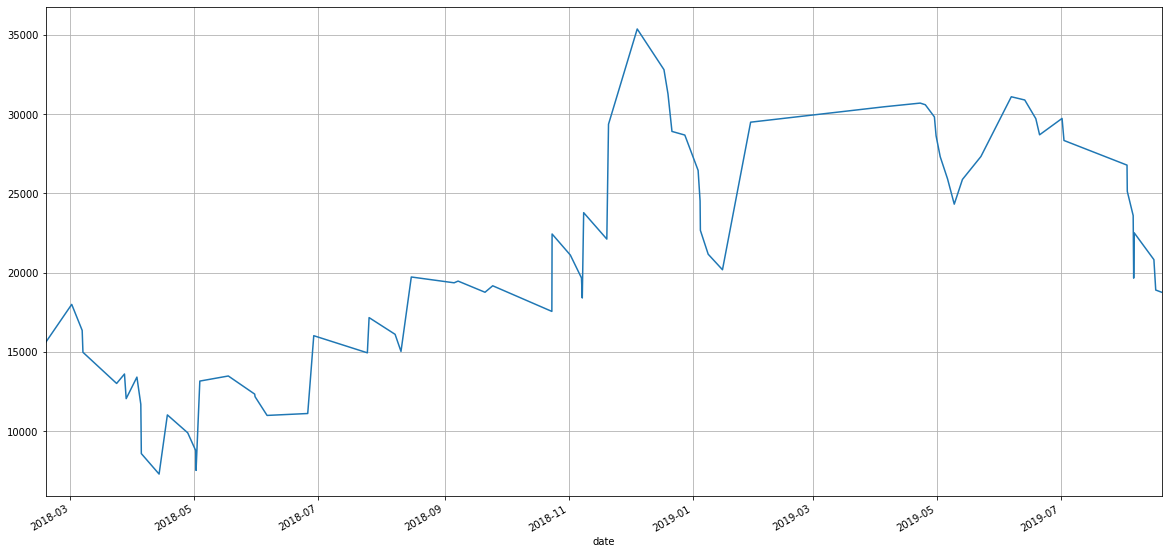

In [33]:
pnl.balance.plot(figsize=(20,10), grid=True);

In [34]:
(pnl.balance.iloc[-1] / pnl.balance.iloc[0]) ** (1/((pnl.index[-1] - daily['return'].index[0]).days/252)) - 1

0.0883112947927891

In [35]:
pnl.balance.iloc[-1] / bankroll - 1

0.25121999999999933

In [37]:
(daily['return'].mean() * 252) / (daily['return'].std() * np.sqrt(252))

0.6207155801424716